# Scrittopoli - Rancking, gironi e calendario

In [20]:
%matplotlib inline

# Import the necessary packages and modules
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import matplotlib.dates  as mpdt
import matplotlib.ticker as mptk

import numpy as np
import pytz
mytz=pytz.timezone("Europe/Rome")
import pandas as pd
import datetime as dt
import math
import importlib
import random
import itertools
import csv
import mylib.spreadsheet as ms


## Definizione dei gironi della fase eliminatoria

Per la determinazione delle teste di serie sono considerate le classifiche:
* classifica generale di MI 2017;
* classifiche di girone di MI 100;
* classifiche di tappa di Ferragosto d'Inchiostro 2017.

Non è considerata la classifica del Contest di Halloween 2017 perché non era un contest per racconti.

Regole per assegnare i punteggi nelle classifiche aggiuntive:
* primo classificato: 5 punti
* secondo classificato: 3 punti
* terzo classificato: 2 punti
* quarto classificato: 1 punto

I gironi saranno da 4 squadre.


In [21]:
MAX_PER_GIRONE=4

mi2017_csv="data/classifica_mi2017.csv"

mi100_12_csv="data/classifica_mi100_1-2.csv"
mi100_34_csv="data/classifica_mi100_3-4.csv"
mi100_56_csv="data/classifica_mi100_5-6.csv"
mi100_78_csv="data/classifica_mi100_7-8.csv"

fdi2017_1_csv="data/fdi2017_1.csv"
fdi2017_2_csv="data/fdi2017_2.csv"
fdi2017_3_csv="data/fdi2017_3.csv"

## Valido solo dal 14 dicembre
squadre_csv="data/squadre.csv"


In [22]:
mi2017=pd.read_csv(mi2017_csv,sep=":",quotechar='"',header=0,index_col=1)

mi100_12=pd.read_csv(mi100_12_csv,sep=",",quotechar='"',header=0,index_col=1)
mi100_12=mi100_12.fillna(0)
mi100_34=pd.read_csv(mi100_34_csv,sep=",",quotechar='"',header=0,index_col=1)
mi100_34=mi100_34.fillna(0)
mi100_56=pd.read_csv(mi100_56_csv,sep=",",quotechar='"',header=0,index_col=1)
mi100_56=mi100_56.fillna(0)
mi100_78=pd.read_csv(mi100_78_csv,sep=",",quotechar='"',header=0,index_col=1)
mi100_78=mi100_78.fillna(0)

fdi2017_1=pd.read_csv(fdi2017_1_csv,sep=",",quotechar='"',header=0,index_col=0)
fdi2017_1=fdi2017_1.fillna(0)
fdi2017_2=pd.read_csv(fdi2017_2_csv,sep=",",quotechar='"',header=0,index_col=0)
fdi2017_2=fdi2017_2.fillna(0)
fdi2017_3=pd.read_csv(fdi2017_3_csv,sep=",",quotechar='"',header=0,index_col=0)
fdi2017_3=fdi2017_3.fillna(0)

squadre=pd.read_csv(squadre_csv,sep=":",quotechar='"',header=0,index_col=1)


### Ranking

In [39]:
tabellone=mi2017.copy()

tabellone=tabellone[["punteggio"]]
tabellone=tabellone.rename(index=str,columns={"punteggio":"mi2017"})

fdi2017_1_v=fdi2017_1[["titolo","voti"]].sort_values(by="voti",ascending=False)[:4]
fdi2017_2_v=fdi2017_2[["titolo","voti"]].sort_values(by="voti",ascending=False)[:5]
fdi2017_3_v=fdi2017_3[["titolo","voti"]].sort_values(by="voti",ascending=False)[:4]

fdi2017_1_v["fdi2017_1"]=[4,4,1.5,1.5]
fdi2017_2_v["fdi2017_2"]=[5,2.5,2.5,.5,.5]
fdi2017_3_v["fdi2017_3"]=[5,3,2,1]

tabellone=tabellone.merge(fdi2017_1_v[["fdi2017_1"]],
                          left_index=True,right_index=True,how="outer")
tabellone=tabellone.merge(fdi2017_2_v[["fdi2017_2"]],
                          left_index=True,right_index=True,how="outer")
tabellone=tabellone.merge(fdi2017_3_v[["fdi2017_3"]],
                          left_index=True,right_index=True,how="outer")

mi100_12_v=mi100_12[["titolo","voti"]].sort_values(by="voti",ascending=False)[:5]
mi100_34_v=mi100_34[["titolo","voti"]].sort_values(by="voti",ascending=False)[:4]
mi100_56_v=mi100_56[["titolo","voti"]].sort_values(by="voti",ascending=False)[:5]
mi100_78_v=mi100_78[["titolo","voti"]].sort_values(by="voti",ascending=False)[:4]

mi100_12_v["mi100_1"]=[5,3,2,.5,.5]
mi100_34_v["mi100_2"]=[5,3,2,1]
mi100_56_v["mi100_3"]=[4,4,1,1,1]
mi100_78_v["mi100_4"]=[5,3,1.5,1.5]

tabellone=tabellone.merge(mi100_12_v.groupby("autore")[["mi100_1"]].sum(),
                          left_index=True,right_index=True,how="outer")
tabellone=tabellone.merge(mi100_34_v.groupby("autore")[["mi100_2"]].sum(),
                          left_index=True,right_index=True,how="outer")
tabellone=tabellone.merge(mi100_56_v.groupby("autore")[["mi100_3"]].sum(),
                          left_index=True,right_index=True,how="outer")
tabellone=tabellone.merge(mi100_78_v.groupby("autore")[["mi100_4"]].sum(),
                          left_index=True,right_index=True,how="outer")


In [40]:
partecipazioni=mi2017.copy()[["num_mi"]]

n=1
for V in [ mi100_12, mi100_34, mi100_56, mi100_78]:
    Q=V[["voti"]].copy()
    Q=Q.rename(index=str,columns={"voti":"mi100_%d" % n})
    Q["c"]=1
    Q=Q.set_index("c",append=True)
    partecipazioni=partecipazioni.merge(Q.count(level=0),
                                        left_index=True,right_index=True,how="outer")
    n=n+1
    
n=1
for V in [ fdi2017_1, fdi2017_2, fdi2017_3]:
    Q=V[["voti"]].copy()
    Q=Q.rename(index=str,columns={"voti":"fdi2017_%d" % n})
    Q["c"]=1
    Q=Q.set_index("c",append=True)
    partecipazioni=partecipazioni.merge(Q.count(level=0),
                                        left_index=True,right_index=True,how="outer")
    n=n+1



In [41]:
tabellone=tabellone.fillna(0)
tabellone["totale"]=tabellone.sum(axis=1)
tabellone.sort_values(by="totale",ascending=False)

partecipazioni=partecipazioni.fillna(0)
partecipazioni["num_gare"]=partecipazioni.sum(axis=1)
partecipazioni.sort_values(by="num_gare",ascending=False)

tabellone=tabellone.merge(partecipazioni[["num_gare"]],
                          left_index=True,right_index=True,how="outer")



In [43]:
tabellone=tabellone.fillna(0)
tabellone

,mi2017,fdi2017_1,fdi2017_2,fdi2017_3,mi100_1,mi100_2,mi100_3,mi100_4,totale,num_gare
AlexComan,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0
Andrea28,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,5.0
AryaSophia,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2.0
Bango Skank,16.50,0.0,0.0,0.0,0.0,0.0,0.0,5.0,21.50,12.0
Befana Profana,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.33,1.0
Cicciuzza,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,1.0
Crazycat,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,2.0
Cristina,3.33,0.0,0.0,0.0,0.0,0.0,4.0,0.0,7.33,5.0
Doria,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3.0
Edison,6.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.66,2.0


In [44]:
scrittopoli=tabellone.copy()
scrittopoli=scrittopoli.merge(squadre,left_index=True,right_index=True,how="right").fillna(0)

scrittopoli=scrittopoli.reset_index().set_index(["squadra","giocatore"])

scrittopoli[["totale"]]

totale
squadra                       giocatore               
Green House                   Bango Skank        21.50
                              Joyopi              7.00
                              Plata               6.00
La threesome                  Komorebi            4.00
                              Luna                0.00
                              mina99              5.83
I Bananari                    Niko                0.00
                              simone volponi     12.00
                              massimopud          5.00
Armata Brancaleone            Ella F.             0.00
                              AdStr               0.00
                              Skorpiòs            0.00
Living Stones                 Macleo             30.33
                              Vincenzo Iennaco    9.33
                              Ljuset              0.00
Retroguardia Trash            Eudes               2.00
                              AlexComan           0.00
                              Andrea28           10.00
Le TreMende                   Emy                 4.00
                              sefora              0.00
                              Thea                0.50
Gli scrittori del quartierino camparino           1.00
                              Federico72          0.00
                              Marty12             0.33
the 3 BrOthers                AryaSophia          0.00
                              ettore70            0.00
                              ITG                 1.00
D Euforiche                   queffe              5.00
                              Marcello           10.00
                              Kuno                5.50

In [45]:
ranking=scrittopoli.groupby("squadra").sum().sort_values(by="totale",ascending=False)[["totale"]]
ranking.reset_index(inplace=True)

ranking

,squadra,totale
0,Living Stones,39.66
1,Green House,34.50
2,D Euforiche,20.50
3,I Bananari,17.00
4,Retroguardia Trash,12.00
5,La threesome,9.83
6,Le TreMende,4.50
7,Gli scrittori del quartierino,1.33
8,the 3 BrOthers,1.00
9,Armata Brancaleone,0.00


### Suddivisione in gironi

In base al numero massimo di squadre in un girone (MAX_PER_GIRONE), viene stabilito il numero dei gironi (num_gironi).

In [46]:
num_squadre=ranking["squadra"].size
num_gironi=int(math.ceil(num_squadre/MAX_PER_GIRONE))
print("Massimo numero di squadre per girone:",MAX_PER_GIRONE)
print("                   Numero di squadre:",num_squadre)
print("                    Numero di gironi:",num_gironi)

Massimo numero di squadre per girone: 4
                   Numero di squadre: 10
                    Numero di gironi: 3


Le squadre vengono suddivise in 4 fasce in base al ranking.

In [47]:
f=1
fasce=[]
for n in range(num_squadre):
    fasce.append("F%d" % f)
    if not (n+1)%num_gironi: f+=1

ranking["fascia"]=fasce

if num_squadre%num_gironi:
    for n in range(num_gironi-num_squadre%num_gironi):
        df2 = pd.DataFrame([["(riposo)",0.0,"F4"]], columns=["squadra","totale","fascia"])
        ranking=ranking.append(df2,ignore_index=True)
    
ranking

,squadra,totale,fascia
0,Living Stones,39.66,F1
1,Green House,34.50,F1
2,D Euforiche,20.50,F1
3,I Bananari,17.00,F2
4,Retroguardia Trash,12.00,F2
5,La threesome,9.83,F2
6,Le TreMende,4.50,F3
7,Gli scrittori del quartierino,1.33,F3
8,the 3 BrOthers,1.00,F3
9,Armata Brancaleone,0.00,F4


In [48]:
gironi_data=[]

for f in ["F1","F2","F3","F4"]:
    f_list=list(ranking[ranking["fascia"]==f]["squadra"])
    random.shuffle(f_list)
    gironi_data.append(f_list)

gironi_labels=[]
for n in range(num_gironi):
    gironi_labels.append(chr(65+n))

gironi=pd.DataFrame(gironi_data,columns=gironi_labels)
gironi

,A,B,C
0,Green House,Living Stones,D Euforiche
1,I Bananari,La threesome,Retroguardia Trash
2,Gli scrittori del quartierino,Le TreMende,the 3 BrOthers
3,(riposo),(riposo),Armata Brancaleone


## Calendario

In [49]:

def calendario(label):
    pivot=gironi[label][0]
    others=list(gironi[label][1:])
    ret=[]
    for n in range(3):
        ret.append( [g,n+1,1,pivot,others[n]] )
        ret.append( [g,n+1,2]+others[:n]+others[n+1:] )
    return ret

calendario_data=[]
for g in gironi_labels:
    calendario_data+=calendario(g)


calendario=pd.DataFrame(calendario_data,columns=["girone","giornata","partita",
                                                 "squadra 1","squadra 2"])

cal_idx=["giornata","girone","partita"]

calendario=calendario.sort_values(by=cal_idx).set_index(cal_idx)
calendario

squadra 1  \
giornata girone partita                                  
1        A      1                          Green House   
                2        Gli scrittori del quartierino   
         B      1                        Living Stones   
                2                          Le TreMende   
         C      1                          D Euforiche   
                2                       the 3 BrOthers   
2        A      1                          Green House   
                2                           I Bananari   
         B      1                        Living Stones   
                2                         La threesome   
         C      1                          D Euforiche   
                2                   Retroguardia Trash   
3        A      1                          Green House   
                2                           I Bananari   
         B      1                        Living Stones   
                2                         La threesome   
         C      1                          D Euforiche   
                2                   Retroguardia Trash   

                                             squadra 2  
giornata girone partita                                 
1        A      1                           I Bananari  
                2                             (riposo)  
         B      1                         La threesome  
                2                             (riposo)  
         C      1                   Retroguardia Trash  
                2                   Armata Brancaleone  
2        A      1        Gli scrittori del quartierino  
                2                             (riposo)  
         B      1                          Le TreMende  
                2                             (riposo)  
         C      1                       the 3 BrOthers  
                2                   Armata Brancaleone  
3        A      1                             (riposo)  
                2        Gli scrittori del quartierino  
         B      1                             (riposo)  
                2                          Le TreMende  
         C      1                   Armata Brancaleone  
                2                       the 3 BrOthers

## Determinazione del ranking Elo dei giocatori

### Formule di base

#### Punteggio atteso di uno scontro

Detti:
* $R_A$ ranking di A
* $R_B$ ranking di B

Il punteggio atteso di una partita per i due giocatori è:

$$E_A=\frac{1}{1+10^{(R_B-R_A)/400}}$$

$$E_B=\frac{1}{1+10^{(R_A-R_B)/400}}=1-E_A$$

#### Risultato reale

Il risultato reale $S$ è ottenuto come:

$$S_A=\frac{G_A}{G_A+G_B}$$

$$S_B=\frac{G_B}{G_A+G_B}$$

Dove $G$ è il numero di goal.

#### Aggiornamento del ranking

La formula per aggiornare il punteggio è:

$$R^{(n+1)}=R^{(n)}+K*\left(S^{(n)}-E^{(n)}\right)$$

Dove
* $R^{(n)}$ è il ranking con cui il giocatore si è presentato alla partita $n$;
* $R^{(n+1)}$ è il ranking con cui il giocatore si presenterà alla partita successiva $n+1$;
* $E^{(n)}$ è il risultato atteso nella partita $n$;
* $S^{(n)}$ è il risultato reale della partita $n$;
* $K$ è il coefficiente di aggiustamento.

### Calcolo dei ranking iniziale

Il valore di un giocatore medio è di 1500.

Il punteggio medio ottenuto è

In [54]:
MEDIA=tabellone.sum()["totale"]/tabellone.sum()["num_gare"]
MEDIA

0.78233766233766244

Mentre la distribuzione delle medie dei punteggi ottenuti, suddivisi per fasce, è:

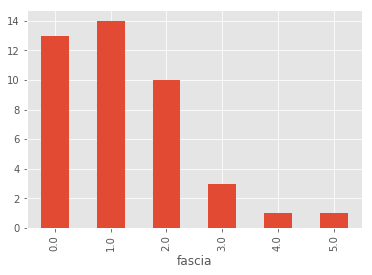

In [57]:
base_ranking=tabellone[["totale","num_gare"]].copy()
base_ranking=base_ranking[base_ranking["totale"]>0]
base_ranking["media"]=base_ranking["totale"]/base_ranking["num_gare"]
base_ranking["fascia"]=base_ranking["media"].round()
base_ranking["c"]=1
base_ranking=base_ranking.set_index("fascia",append=True)
x=base_ranking["c"].count(level=1).plot.bar()


Si ottengono quindi 6 fasce. La fascia che corrisponde alla media è la fascia 1, per cui si assume che:

$$ R_{F1}=1500 $$

Per calcolare gli altri ranking, partiamo da un risultato atteso tra due giocatori di due fasce $x$ e $y$ ($E_{ab}$ è il risultato atteso di a quando gioca con b) del tipo:

$$E_{xy}=\frac{F_x+1}{F_x+F_y+2}=1-E_{yx}$$

Dove $F_0=0, F_1=1, ...$.

Dalla formula:

$$E_{xy}=\frac{1}{1+10^{(R_y-Rx)/Q}}$$

si ottiene:

$$E_{xy}=\frac{F_x+1}{F_x+F_y+2}=\frac{1}{1+10^{(R_y-Rx)/Q}}$$

$$\frac{F_x+F_y+2}{F_x+1}=1+10^{(R_y-Rx)/Q}$$

$$F_x+F_y+2=F_x+1+(F_x+1)10^{(R_y-Rx)/Q}$$

$$F_y+1=(F_x+1)10^{(R_y-Rx)/Q}$$

$$\frac{F_y+1}{F_x+1}=10^{(R_y-Rx)/Q}$$

$$\log_{10}\left(\frac{F_y+1}{F_x+1}\right)=\frac{R_y-Rx}{Q}$$

$$R_y=R_x+Q\,\log_{10}\left(\frac{F_y+1}{F_x+1}\right)$$

Nel nostro range $Q=400$ (usato nelle altre formule) porta a valori troppo distanti tra loro, per cui lo abbassiamo a $Q=200$.

Generalizzando la formula, è quindi possibile calcolare il ranking di base di ogni giocatore $g$ come:

$$R^{(0)}_g=M_R+Q\,\log_{10}\left(\frac{p_g+1}{m_p+1}\right)$$

dove:

* $R^{(0)}_g$ è il ranking base del giocatore g;
* $M_R$ è il ranking medio (per convenzione 1500);
* $p_g$ è il punteggio medio di ogni giocatore;
* $m_p$ è la media dei punteggi;
* $Q=200$.

Inoltre si impone che il ranking minimo per un giocatore sia 1450. 

In [73]:
def stima_ranking(fx,fy,rx):
    ry=rx+200*math.log10((fy+1)/(fx+1))
    return round(ry)

MIN_ELO=1450

def stima_ranking_zero(pg):
    return max(1450,stima_ranking(MEDIA,pg,MIN_ELO))

rm=1500
r1=stima_ranking(0.78,1,rm)
r2=stima_ranking(0.78,2,rm)
r3=stima_ranking(0.78,3,rm)
r4=stima_ranking(0.78,4,rm)
r5=stima_ranking(0.78,5,rm)
r0=stima_ranking(0.78,0,rm)

print([r0,r1,r2,r3,r4,r5])


[1450, 1510, 1545, 1570, 1590, 1606]


In [74]:
elo_giocatori=tabellone[["totale","num_gare"]].copy()
elo_giocatori["media"]=elo_giocatori["totale"]/elo_giocatori["num_gare"]

elo_giocatori["rank 0"]=elo_giocatori["media"].apply(stima_ranking_zero)
elo_giocatori.sort_values(by="media",ascending=False)


,totale,num_gare,media,rank 0
queffe,5.00,1.0,5.000000,1555
wyjkz31,4.00,1.0,4.000000,1540
Befana Profana,3.33,1.0,3.330000,1527
Edison,6.66,2.0,3.330000,1527
JMC,3.00,1.0,3.000000,1520
Rewind,2.50,1.0,2.500000,1509
massimopud,5.00,2.0,2.500000,1509
Nerio,5.00,2.0,2.500000,1509
Andrea28,10.00,5.0,2.000000,1495
Marcello,10.00,5.0,2.000000,1495


In [75]:
elo_squadre=scrittopoli[["totale","num_gare"]].copy()
elo_squadre["media"]=elo_squadre["totale"]/elo_squadre["num_gare"]
elo_squadre=elo_squadre.reset_index().set_index("giocatore")

elo_squadre=elo_squadre.merge(elo_ranking[["rank 0"]],
                                                left_index=True,right_index=True,how="left")
elo_squadre=elo_squadre.reset_index().set_index(["squadra","giocatore"])

elo_squadre["media"]=elo_squadre["media"].fillna(0)
elo_squadre["rank 0"]=elo_squadre["rank 0"].fillna(MIN_ELO)

elo_squadre

totale  num_gare     media  \
squadra                       giocatore                                      
Green House                   Bango Skank        21.50      12.0  1.791667   
                              Joyopi              7.00      15.0  0.466667   
                              Plata               6.00      11.0  0.545455   
La threesome                  Komorebi            4.00       8.0  0.500000   
                              Luna                0.00       3.0  0.000000   
                              mina99              5.83       7.0  0.832857   
I Bananari                    Niko                0.00       0.0  0.000000   
                              simone volponi     12.00      19.0  0.631579   
                              massimopud          5.00       2.0  2.500000   
Armata Brancaleone            Ella F.             0.00       0.0  0.000000   
                              AdStr               0.00       0.0  0.000000   
                              Skorpiòs            0.00       0.0  0.000000   
Living Stones                 Macleo             30.33      19.0  1.596316   
                              Vincenzo Iennaco    9.33      18.0  0.518333   
                              Ljuset              0.00       0.0  0.000000   
Retroguardia Trash            Eudes               2.00       1.0  2.000000   
                              AlexComan           0.00       1.0  0.000000   
                              Andrea28           10.00       5.0  2.000000   
Le TreMende                   Emy                 4.00      19.0  0.210526   
                              sefora              0.00       1.0  0.000000   
                              Thea                0.50       5.0  0.100000   
Gli scrittori del quartierino camparino           1.00      10.0  0.100000   
                              Federico72          0.00      10.0  0.000000   
                              Marty12             0.33       4.0  0.082500   
the 3 BrOthers                AryaSophia          0.00       2.0  0.000000   
                              ettore70            0.00       0.0  0.000000   
                              ITG                 1.00       1.0  1.000000   
D Euforiche                   queffe              5.00       1.0  5.000000   
                              Marcello           10.00       5.0  2.000000   
                              Kuno                5.50       3.0  1.833333   

                                                rank 0  
squadra                       giocatore                 
Green House                   Bango Skank       1539.0  
                              Joyopi            1483.0  
                              Plata             1488.0  
La threesome                  Komorebi          1485.0  
                              Luna              1450.0  
                              mina99            1502.0  
I Bananari                    Niko              1450.0  
                              simone volponi    1492.0  
                              massimopud        1559.0  
Armata Brancaleone            Ella F.           1450.0  
                              AdStr             1450.0  
                              Skorpiòs          1450.0  
Living Stones                 Macleo            1533.0  
                              Vincenzo Iennaco  1486.0  
                              Ljuset            1450.0  
Retroguardia Trash            Eudes             1545.0  
                              AlexComan         1450.0  
                              Andrea28          1545.0  
Le TreMende                   Emy               1466.0  
                              sefora            1450.0  
                              Thea              1458.0  
Gli scrittori del quartierino camparino         1458.0  
                              Federico72        1450.0  
                              Marty12           1457.0  
the 3 BrOthers                AryaSophia        1450.0  
            

## Salvataggio dei risultati

### CSV

In [76]:
# calendario
d=dt.datetime.today()
label=d.strftime("%Y%m%d_%H%M%S")
calendario_csv="data/calendario_"+label+".csv"
with open(calendario_csv, 'w', newline='') as csvfile:
    w = csv.writer(csvfile,delimiter=':',
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)
    w.writerow(["girone","giornata","partita","squadra 1","squadra 2"])
    for row in calendario_data:
        w.writerow(row)
        
# gironi
label=d.strftime("%Y%m%d_%H%M%S")
gironi_csv="data/gironi_"+label+".csv"
with open(gironi_csv, 'w', newline='') as csvfile:
    w = csv.writer(csvfile,delimiter=':',
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)
    w.writerow(gironi_labels)
    for row in gironi_data:
        w.writerow(row)
        
# ranking
tabellone_csv="data/tabellone_"+label+".csv"
tabellone.to_csv(tabellone_csv,index_label="utente")
ranking_csv="data/ranking_"+label+".csv"
ranking.to_csv(ranking_csv,index=False)
scrittopoli_csv="data/scrittopoli_"+label+".csv"
scrittopoli.to_csv(scrittopoli_csv)

# elo
elo_squadre_csv="data/elo_squadre_"+label+".csv"
elo_squadre.to_csv(elo_squadre_csv)
elo_giocatori_csv="data/elo_giocatori_"+label+".csv"
elo_giocatori.to_csv(elo_giocatori_csv,index_label="utente")


### Google spreadsheet

In [77]:
importlib.reload(ms)
s=ms.N2017Spreadsheet()

# gironi
s.set_gironi(gironi_labels,gironi_data)

# calendario
q=calendario.reset_index()
r=[list(x) for x in q.as_matrix()]
s.set_calendario(gironi_labels,r)

# ranking generale
rank_labels=["totale","num_gare","mi2017","fdi2017_1","fdi2017_2","fdi2017_3",
             "mi100_1","mi100_2","mi100_3","mi100_4"]
q=tabellone[rank_labels].sort_values(by="totale",ascending=False).reset_index()
r=[list(x) for x in q.as_matrix()]
s.set_ranking_generale(rank_labels,r)

# ranking squadre
labels=["fascia","squadra","totale"]
r=[list(x) for x in ranking[labels].as_matrix()]
s.set_ranking_squadre(labels,r,len(gironi_labels))

# ranking giocatori
q=scrittopoli[rank_labels].reset_index()
r=[list(x) for x in q.as_matrix()]
s.set_ranking_giocatori(rank_labels,r)

# elo giocatori
rank_labels=["totale","num_gare","media","rank 0"]
q=elo_giocatori[rank_labels].sort_values(by="media",ascending=False).reset_index()
r=[list(x) for x in q.as_matrix()]
s.set_elo_giocatori(rank_labels,r)

# elo squadre
q=elo_squadre[rank_labels].reset_index()
r=[list(x) for x in q.as_matrix()]
s.set_elo_squadre(rank_labels,r)

